## 1.   Libraries








In [ ]:
!nvidia-smi

In [ ]:
import numpy as np



import cv2
from google.colab.patches import cv2_imshow



from pathlib import Path
from google.colab import drive
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, Reshape, DepthwiseConv2D, BatchNormalization, ReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.losses import SparseCategoricalCrossentropy

!pip install -q tensorflow-model-optimization

import tensorflow_model_optimization as tfmot

import sklearn
from sklearn.metrics import accuracy_score

BATCH_SIZE = 32
EPOCHS = 100
img_height = 28
img_width = 28
N_CLASSES = 62

     |████████████████████████████████| 238 kB 4.0 MB/s 


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

data_path = '/content/gdrive/MyDrive/Internet of Things/data'
os.path.exists(data_path)

Mounted at /content/gdrive


True

In [ ]:
model_path = '/content/gdrive/MyDrive/Internet of Things/Modelli/'

## 2.   Load and preprocess images

the dataset is composed of the image path and the label. So we first need to load the image from the disk and apply the preprocessing (standardize resizing and convert to grayscale).

In [ ]:
df = pd.read_csv(os.path.join(data_path, "dataset", "english.csv"))
df.image = "/dataset/" + df.image
print(df.shape)
df.head()

(3410, 2)


,image,label
0,/dataset/Img/img001-001.png,0
1,/dataset/Img/img001-002.png,0
2,/dataset/Img/img001-003.png,0
3,/dataset/Img/img001-004.png,0
4,/dataset/Img/img001-005.png,0


In [ ]:
df_handmade = pd.read_csv(os.path.join(data_path, "handmade", "english.csv"))
df_handmade.image = "/handmade/" + df_handmade.image
print(df_handmade.shape)

df_handmade.head()

(1984, 2)


,image,label
0,/handmade/Img/img-0000.png,h
1,/handmade/Img/img-0001.png,h
2,/handmade/Img/img-0002.png,h
3,/handmade/Img/img-0003.png,h
4,/handmade/Img/img-0004.png,h


In [ ]:
def generate_dataset( df):
  imgs = []
  labels = []
  for name, label in tqdm(df.values):
    path = data_path + name
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255

    imgs.append(img)
    labels.append(label)

  imgs = np.array(imgs)
  labels = np.array(labels)
  return imgs, labels



In [ ]:
imgs, labels = generate_dataset(df)
with open(os.path.join(data_path, "data_28.pickle"), 'wb') as f:
    pickle.dump((imgs, labels), f)

In [ ]:
imgs_hd, labels_hd = generate_dataset(df_handmade)
with open(os.path.join(data_path, "data_handmade_28.pickle"), 'wb') as f:
    pickle.dump((imgs_hd, labels_hd), f)

In [ ]:
with open(os.path.join(data_path, "data_28.pickle"), 'rb') as f:
    (imgs, labels) = pickle.load(f)

with open(os.path.join(data_path, "data_handmade_28.pickle"), 'rb') as f:
    (imgs_hd, labels_hd) = pickle.load(f)

In [ ]:

with open(os.path.join(data_path, "data.pickle"), 'rb') as f:
    (small_imgs, small_labels) = pickle.load(f)
    
with open(os.path.join(data_path, "data_handmade.pickle"), 'rb') as f:
    (small_imgs_hd, small_labels_hd) = pickle.load(f)


example of the image and label in both size (28x28 and 23x30)

In [ ]:

img_idx = np.random.randint(0, imgs.shape[0])
print(f"label: {labels[img_idx]} \n")
cv2_imshow(imgs[img_idx] * 255)
print(imgs[img_idx].shape)

label: A 



(28, 28)


In [ ]:
img_idx = np.random.randint(0,  small_imgs.shape[0])
print(f"label: {small_labels_hd[img_idx]} \n")
cv2_imshow(small_imgs_hd[img_idx] * 255)
print(small_imgs_hd[img_idx].shape)

label: J 



(23, 30)


We cannot directly predict the alphanumeric label but we need first to map it to an integer number.

In [ ]:
label_to_index_mapping = {x: i for i, x in enumerate(np.unique(labels))}
index_to_labels_mapping = { i:x for i,x in enumerate(np.unique(labels))}
labels_index = np.array([label_to_index_mapping[label] for label in labels])
labels_index_hd = np.array([label_to_index_mapping[label] for label in labels_hd])

In [ ]:
small_labels_index = np.array([label_to_index_mapping[label] for label in small_labels])
small_labels_index_hd = np.array([label_to_index_mapping[label] for label in small_labels_hd])

In [ ]:
label_to_index_mapping

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 'a': 36,
 'b': 37,
 'c': 38,
 'd': 39,
 'e': 40,
 'f': 41,
 'g': 42,
 'h': 43,
 'i': 44,
 'j': 45,
 'k': 46,
 'l': 47,
 'm': 48,
 'n': 49,
 'o': 50,
 'p': 51,
 'q': 52,
 'r': 53,
 's': 54,
 't': 55,
 'u': 56,
 'v': 57,
 'w': 58,
 'x': 59,
 'y': 60,
 'z': 61}

In [ ]:
imgs_concat = np.concatenate([imgs, imgs_hd])
labels_concat = np.concatenate([labels_index, labels_index_hd])

small_imgs_concat = np.concatenate([small_imgs, small_imgs_hd])
small_labels_concat = np.concatenate([small_labels_index, small_labels_index_hd])

### 2.1. Train test split

we split the dataset in train validation and test set.

In [ ]:
def train_test_split(data, train_size):
  imgs, labels = data
  X_train = []
  y_train = []
  X_test = []
  y_test = []
  indexes = np.argsort(labels)
  for group in tqdm(np.split(indexes, N_CLASSES)):
    np.random.shuffle(group)
    X_train.extend(imgs[group[:train_size]])
    y_train.extend(labels[group[:train_size]])

    X_test.extend(imgs[group[train_size:]])
    y_test.extend(labels[group[train_size:]])

  return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

#### train test split 28x28 images

In [ ]:

train_size = round(55 * .95)

X_train, X_test, y_train, y_test = train_test_split((imgs, labels_index), train_size)
X_train, X_val, y_train, y_val = train_test_split((X_train, y_train), round(55 * .85))
print(f"\n\ntrain size: {X_train.shape[0]}, val size: {X_val.shape[0]}, test size: {X_test.shape[0]}")

100%|██████████| 62/62 [00:00<00:00, 4589.60it/s]



train size: 2914, val size: 310, test size: 186


In [ ]:
train_size = round(32 * .95)

X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split((imgs_hd, labels_index_hd), train_size)
X_train_hd, X_val_hd, y_train_hd, y_val_hd = train_test_split((X_train_hd, y_train_hd), round(32 * .85))
print(f"\n\ntrain size: {X_train_hd.shape[0]}, val size: {X_val_hd.shape[0]}, test size: {X_test_hd.shape[0]}")


100%|██████████| 62/62 [00:00<00:00, 6653.54it/s]



train size: 1674, val size: 186, test size: 124


In [ ]:
train_size = round(87 * .95)

X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split((imgs_concat, labels_concat), train_size)
X_train_concat, X_val_concat, y_train_concat, y_val_concat = train_test_split((X_train_concat, y_train_concat), round(87 * .85))

print(f"\n\ntrain size: {X_train_concat.shape[0]}, val size: {X_val_concat.shape[0]}, test size: {X_test_concat.shape[0]}")


100%|██████████| 62/62 [00:00<00:00, 3889.48it/s]




train size: 4588, val size: 558, test size: 248


#### train test split 23x30  images

In [ ]:
train_size = round(32 * .95)

small_X_train, small_X_test, small_y_train, small_y_test = train_test_split((small_imgs, small_labels_index), train_size)
small_X_train, small_X_val, small_y_train, small_y_val = train_test_split((small_X_train, small_y_train), round(32 * .85))
print(f"\n\ntrain size: {small_X_train.shape[0]}, val size: {small_X_val.shape[0]}, test size: {small_X_test.shape[0]}")


100%|██████████| 62/62 [00:00<00:00, 9040.39it/s]




train size: 1674, val size: 186, test size: 1550


In [ ]:
train_size = round(32 * .95)

small_X_train_hd, small_X_test_hd, small_y_train_hd, small_y_test_hd = train_test_split((small_imgs_hd, small_labels_index_hd), train_size)
small_X_train_hd, small_X_val_hd, small_y_train_hd, small_y_val_hd = train_test_split((small_X_train_hd, small_y_train_hd), round(32 * .85))
print(f"\n\ntrain size: {small_X_train_hd.shape[0]}, val size: {small_X_val_hd.shape[0]}, test size: {small_X_test_hd.shape[0]}")


100%|██████████| 62/62 [00:00<00:00, 9749.81it/s]



train size: 1674, val size: 186, test size: 124


In [ ]:
train_size = round(87 * .95)

small_X_train_concat, small_X_test_concat, small_y_train_concat, small_y_test_concat = train_test_split((small_imgs_concat, small_labels_concat), train_size)
small_X_train_concat, small_X_val_concat, small_y_train_concat, small_y_val_concat = train_test_split((small_X_train_concat, small_y_train_concat), round(87 * .85))

print(f"\n\ntrain size: {small_X_train_concat.shape[0]}, val size: {small_X_val_concat.shape[0]}, test size: {small_X_test_concat.shape[0]}")

100%|██████████| 62/62 [00:00<00:00, 3968.12it/s]




train size: 4588, val size: 558, test size: 248


## 3. Create the model

Since we are restricted from the hardware capacity of the device we cannot use a complex model. So we rely on the lenet5 model and on a modified version.

### 3.1 lenet5 model

In [ ]:
def lenet5():
  lenet5 = Sequential()
  lenet5.add(Reshape((img_height, img_width, 1), input_shape=(img_height, img_width))) # inpust shape 28x28

  lenet5.add(Conv2D(filters=6, kernel_size=(5,5),  padding = 'same', activation='tanh' ))
  lenet5.add(AveragePooling2D())
  lenet5.add(Conv2D(filters=16, kernel_size=(5,5), activation='tanh', padding='valid'))


  lenet5.add(AveragePooling2D())
  lenet5.add(Conv2D(filters=120, kernel_size=(5,5),activation ="tanh", padding='valid'))
  lenet5.add(Flatten())
  lenet5.add(Dense(84,activation ="relu"))
  lenet5.add(tf.keras.layers.Dropout(.4))
  lenet5.add(Dense(N_CLASSES,activation ="softmax"))
  lenet5.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  
  return lenet5

# trained on the main dataset
model_lenet5 = lenet5()
# trained on the handcrafted dataset
model_lenet5_hd = lenet5()
# trained on the concatenation of both dataset
model_lenet5_concat = lenet5()

model_lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         4

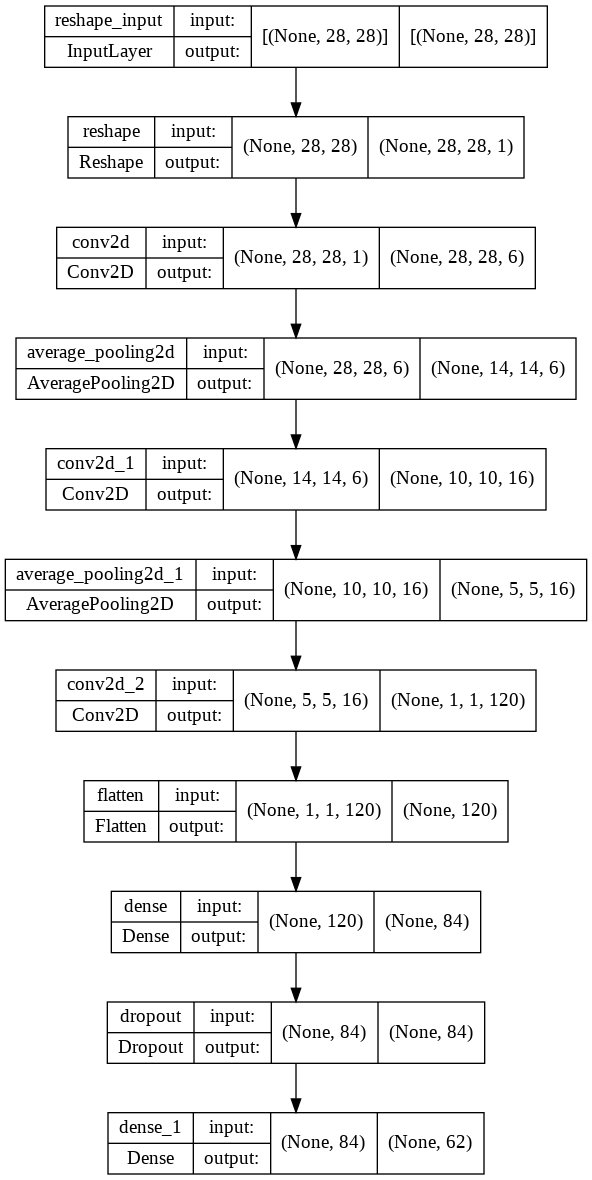

In [ ]:
tf.keras.utils.plot_model(model_lenet5, show_shapes=True,)

## 3.2 modified lenet5

In [ ]:
def modified_lenet():
  modified_lenet = Sequential()
  modified_lenet.add(Reshape((23, 30, 1), input_shape=(23, 30))) # input shape 23x30

  modified_lenet.add(Conv2D(filters=6, kernel_size=(5,5),  padding = 'same', activation='tanh' ))
  modified_lenet.add(AveragePooling2D())
  modified_lenet.add(Conv2D(filters=16, kernel_size=(5,5), activation='tanh', padding='valid'))
  modified_lenet.add(AveragePooling2D())
  modified_lenet.add(Flatten())
  modified_lenet.add(Dense(256, activation ="relu"))
  modified_lenet.add(tf.keras.layers.Dropout(.4))
  modified_lenet.add(Dense(N_CLASSES,activation ="softmax"))

  modified_lenet.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  return modified_lenet

# trained on the main dataset
modified_model_lenet5 = modified_lenet()
# trained on the handcrafted dataset
modified_model_lenet5_hd = modified_lenet()
# trained on the concatenation of both dataset
modified_model_lenet5_concat = modified_lenet()
modified_model_lenet5_hd.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 23, 30, 1)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 23, 30, 6)         156       
                                                                 
 average_pooling2d_8 (Averag  (None, 11, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 11, 16)         2416      
                                                                 
 average_pooling2d_9 (Averag  (None, 3, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 240)              

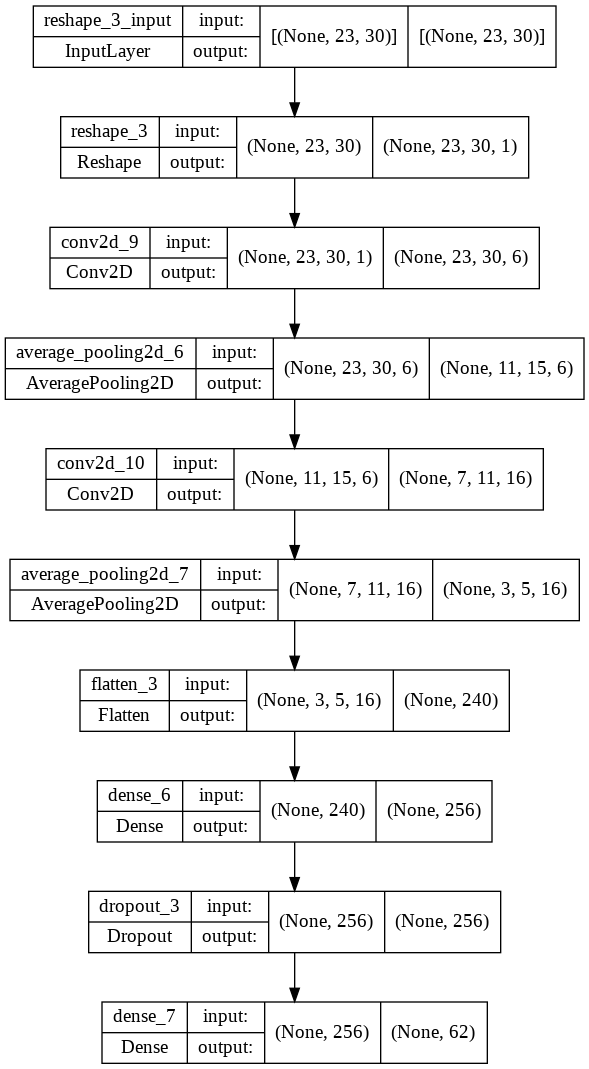

In [ ]:
tf.keras.utils.plot_model(modified_model_lenet5, show_shapes=True,)

## 4. Train the model

we train a different model for each dataset for 100 epochs on batch of size 32 elements. We apply an early stopping callback on the validation loss to avoid overfitting  the model. 

#### train on 28x28 dataset and original lenet5 model

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lenet5.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[callback])

Epoch 1/100
92/92 [==============================] - 3s 25ms/step - loss: 4.1227 - accuracy: 0.0209 - val_loss: 4.0728 - val_accuracy: 0.0742
Epoch 2/100
92/92 [==============================] - 2s 23ms/step - loss: 3.8730 - accuracy: 0.0721 - val_loss: 3.5239 - val_accuracy: 0.1548
Epoch 3/100
92/92 [==============================] - 2s 23ms/step - loss: 3.4158 - accuracy: 0.1407 - val_loss: 3.1645 - val_accuracy: 0.2548
Epoch 4/100
92/92 [==============================] - 2s 23ms/step - loss: 3.0868 - accuracy: 0.2025 - val_loss: 2.9243 - val_accuracy: 0.2871
Epoch 5/100
92/92 [==============================] - 2s 23ms/step - loss: 2.8884 - accuracy: 0.2392 - val_loss: 2.7403 - val_accuracy: 0.3452
Epoch 6/100
92/92 [==============================] - 2s 23ms/step - loss: 2.6957 - accuracy: 0.2701 - val_loss: 2.6465 - val_accuracy: 0.3452
Epoch 7/100
92/92 [==============================] - 2s 23ms/step - loss: 2.5282 - accuracy: 0.3123 - val_loss: 2.5262 - val_accuracy: 0.3548
Epoch 

In [ ]:
history = model_lenet5_hd.fit(X_train_hd, y_train_hd, validation_data = (X_val_hd, y_val_hd), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[callback])

Epoch 1/100
53/53 [==============================] - 2s 27ms/step - loss: 4.1177 - accuracy: 0.0215 - val_loss: 4.0500 - val_accuracy: 0.0323
Epoch 2/100
53/53 [==============================] - 1s 24ms/step - loss: 3.8133 - accuracy: 0.0830 - val_loss: 3.2943 - val_accuracy: 0.2204
Epoch 3/100
53/53 [==============================] - 1s 24ms/step - loss: 3.0641 - accuracy: 0.2288 - val_loss: 2.4074 - val_accuracy: 0.4140
Epoch 4/100
53/53 [==============================] - 1s 24ms/step - loss: 2.3724 - accuracy: 0.3763 - val_loss: 1.8717 - val_accuracy: 0.5914
Epoch 5/100
53/53 [==============================] - 1s 24ms/step - loss: 1.9656 - accuracy: 0.4725 - val_loss: 1.5398 - val_accuracy: 0.6290
Epoch 6/100
53/53 [==============================] - 1s 24ms/step - loss: 1.6660 - accuracy: 0.5436 - val_loss: 1.2844 - val_accuracy: 0.7097
Epoch 7/100
53/53 [==============================] - 1s 24ms/step - loss: 1.4210 - accuracy: 0.6123 - val_loss: 1.1332 - val_accuracy: 0.7258
Epoch 

In [ ]:
history = model_lenet5_concat.fit(X_train_concat, y_train_concat, validation_data = (X_val_concat, y_val_concat), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[callback])

Epoch 1/100
144/144 [==============================] - 4s 25ms/step - loss: 4.1205 - accuracy: 0.0218 - val_loss: 4.0462 - val_accuracy: 0.0484
Epoch 2/100
144/144 [==============================] - 4s 24ms/step - loss: 3.7743 - accuracy: 0.0769 - val_loss: 3.3154 - val_accuracy: 0.1864
Epoch 3/100
144/144 [==============================] - 4s 24ms/step - loss: 3.2380 - accuracy: 0.1731 - val_loss: 2.7891 - val_accuracy: 0.3154
Epoch 4/100
144/144 [==============================] - 4s 25ms/step - loss: 2.8149 - accuracy: 0.2685 - val_loss: 2.4243 - val_accuracy: 0.3853
Epoch 5/100
144/144 [==============================] - 4s 24ms/step - loss: 2.5660 - accuracy: 0.3211 - val_loss: 2.2642 - val_accuracy: 0.3996
Epoch 6/100
144/144 [==============================] - 3s 24ms/step - loss: 2.3566 - accuracy: 0.3640 - val_loss: 2.0646 - val_accuracy: 0.4552
Epoch 7/100
144/144 [==============================] - 3s 24ms/step - loss: 2.1560 - accuracy: 0.4039 - val_loss: 1.9187 - val_accuracy:

#### train on 23x30 dataset and modified lene5 model

In [ ]:
history = modified_model_lenet5.fit(small_X_train, small_y_train, validation_data = (small_X_val, small_y_val), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[callback])

Epoch 1/100
53/53 [==============================] - 2s 25ms/step - loss: 4.1348 - accuracy: 0.0197 - val_loss: 4.1047 - val_accuracy: 0.0215
Epoch 2/100
53/53 [==============================] - 1s 21ms/step - loss: 4.0749 - accuracy: 0.0346 - val_loss: 4.0123 - val_accuracy: 0.0753
Epoch 3/100
53/53 [==============================] - 1s 22ms/step - loss: 3.8403 - accuracy: 0.0830 - val_loss: 3.6112 - val_accuracy: 0.1075
Epoch 4/100
53/53 [==============================] - 1s 22ms/step - loss: 3.3544 - accuracy: 0.1697 - val_loss: 3.3228 - val_accuracy: 0.1559
Epoch 5/100
53/53 [==============================] - 1s 21ms/step - loss: 3.0550 - accuracy: 0.2127 - val_loss: 3.1823 - val_accuracy: 0.2151
Epoch 6/100
53/53 [==============================] - 1s 22ms/step - loss: 2.8569 - accuracy: 0.2616 - val_loss: 3.0589 - val_accuracy: 0.2419
Epoch 7/100
53/53 [==============================] - 1s 21ms/step - loss: 2.6494 - accuracy: 0.3130 - val_loss: 3.0046 - val_accuracy: 0.2473
Epoch 

In [ ]:
history = modified_model_lenet5_hd.fit(small_X_train_hd, small_y_train_hd, validation_data = (small_X_val_hd, small_y_val_hd), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[callback])

Epoch 1/100
53/53 [==============================] - 2s 25ms/step - loss: 4.1009 - accuracy: 0.0388 - val_loss: 4.0085 - val_accuracy: 0.1559
Epoch 2/100
53/53 [==============================] - 1s 23ms/step - loss: 3.7374 - accuracy: 0.1458 - val_loss: 3.1275 - val_accuracy: 0.3172
Epoch 3/100
53/53 [==============================] - 1s 22ms/step - loss: 2.7269 - accuracy: 0.3112 - val_loss: 2.0022 - val_accuracy: 0.6075
Epoch 4/100
53/53 [==============================] - 1s 22ms/step - loss: 1.9598 - accuracy: 0.4982 - val_loss: 1.4712 - val_accuracy: 0.6613
Epoch 5/100
53/53 [==============================] - 1s 22ms/step - loss: 1.5614 - accuracy: 0.5926 - val_loss: 1.2377 - val_accuracy: 0.7043
Epoch 6/100
53/53 [==============================] - 1s 22ms/step - loss: 1.3058 - accuracy: 0.6428 - val_loss: 1.0294 - val_accuracy: 0.7366
Epoch 7/100
53/53 [==============================] - 1s 22ms/step - loss: 1.1433 - accuracy: 0.6864 - val_loss: 0.9240 - val_accuracy: 0.7581
Epoch 

In [ ]:
history = modified_model_lenet5_concat.fit(small_X_train_concat, small_y_train_concat, validation_data = (small_X_val_concat, small_y_val_concat), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[callback])

Epoch 1/100
144/144 [==============================] - 4s 23ms/step - loss: 4.0531 - accuracy: 0.0475 - val_loss: 3.6719 - val_accuracy: 0.1254
Epoch 2/100
144/144 [==============================] - 3s 22ms/step - loss: 3.2338 - accuracy: 0.1962 - val_loss: 2.7682 - val_accuracy: 0.2993
Epoch 3/100
144/144 [==============================] - 3s 22ms/step - loss: 2.6440 - accuracy: 0.3298 - val_loss: 2.3656 - val_accuracy: 0.4014
Epoch 4/100
144/144 [==============================] - 3s 22ms/step - loss: 2.3248 - accuracy: 0.3838 - val_loss: 2.1525 - val_accuracy: 0.4516
Epoch 5/100
144/144 [==============================] - 3s 21ms/step - loss: 2.0841 - accuracy: 0.4547 - val_loss: 2.0079 - val_accuracy: 0.4624
Epoch 6/100
144/144 [==============================] - 3s 22ms/step - loss: 1.9145 - accuracy: 0.4863 - val_loss: 1.8912 - val_accuracy: 0.4910
Epoch 7/100
144/144 [==============================] - 3s 22ms/step - loss: 1.8145 - accuracy: 0.5111 - val_loss: 1.7854 - val_accuracy:

### 4.1. Quantization-aware training

post-processing quantization techniques rely on the reduction of the precision of the weights and the activation function and this can lead to a reduction in the accuracy. Quantization aware training emulates inference-time quantization. This avoids the reduction in accuracy of the deployed model.

In [ ]:


quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model_lenet5)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# q_aware stands for for quantization aware.
q_aware_model_hd = quantize_model(model_lenet5_hd)

# `quantize_model` requires a recompile.
q_aware_model_hd.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# q_aware stands for for quantization aware.
q_aware_model_concat = quantize_model(model_lenet5_concat)

# `quantize_model` requires a recompile.
q_aware_model_concat.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# q_aware stands for for quantization aware.
small_q_aware_model = quantize_model(modified_model_lenet5)

# `quantize_model` requires a recompile.
small_q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# q_aware stands for for quantization aware.
small_q_aware_model_hd = quantize_model(modified_model_lenet5_hd)

# `quantize_model` requires a recompile.
small_q_aware_model_hd.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# q_aware stands for for quantization aware.
small_q_aware_model_concat = quantize_model(modified_model_lenet5_concat)

# `quantize_model` requires a recompile.
small_q_aware_model_concat.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

q_aware_model.fit(X_val, y_val, epochs=5)

Epoch 1/5
10/10 [==============================] - 1s 26ms/step - loss: 2.1144 - accuracy: 0.4097
Epoch 2/5
10/10 [==============================] - 0s 27ms/step - loss: 1.7931 - accuracy: 0.4710
Epoch 3/5
10/10 [==============================] - 0s 27ms/step - loss: 1.5073 - accuracy: 0.5226
Epoch 4/5
10/10 [==============================] - 0s 26ms/step - loss: 1.3031 - accuracy: 0.6097
Epoch 5/5
10/10 [==============================] - 0s 26ms/step - loss: 1.2592 - accuracy: 0.6000


In [ ]:
q_aware_model_hd.fit(X_val_hd, y_val_hd, epochs=5)

Epoch 1/5
6/6 [==============================] - 2s 27ms/step - loss: 0.9551 - accuracy: 0.7204
Epoch 2/5
6/6 [==============================] - 0s 26ms/step - loss: 0.7157 - accuracy: 0.8333
Epoch 3/5
6/6 [==============================] - 0s 24ms/step - loss: 0.5220 - accuracy: 0.8495
Epoch 4/5
6/6 [==============================] - 0s 25ms/step - loss: 0.4889 - accuracy: 0.8710
Epoch 5/5
6/6 [==============================] - 0s 28ms/step - loss: 0.5683 - accuracy: 0.8602


In [ ]:
q_aware_model_concat.fit(X_val_concat, y_val_concat, epochs=5)

Epoch 1/5
18/18 [==============================] - 2s 26ms/step - loss: 1.5506 - accuracy: 0.5251
Epoch 2/5
18/18 [==============================] - 0s 26ms/step - loss: 1.2156 - accuracy: 0.6111
Epoch 3/5
18/18 [==============================] - 0s 25ms/step - loss: 1.1362 - accuracy: 0.6183
Epoch 4/5
18/18 [==============================] - 0s 26ms/step - loss: 0.9926 - accuracy: 0.6828
Epoch 5/5
18/18 [==============================] - 0s 25ms/step - loss: 0.8892 - accuracy: 0.7222


In [ ]:
small_q_aware_model.fit(small_X_val, small_y_val, epochs = 5)

Epoch 1/5
6/6 [==============================] - 1s 24ms/step - loss: 2.6873 - accuracy: 0.3495
Epoch 2/5
6/6 [==============================] - 0s 23ms/step - loss: 2.4521 - accuracy: 0.4355
Epoch 3/5
6/6 [==============================] - 0s 24ms/step - loss: 2.1378 - accuracy: 0.4624
Epoch 4/5
6/6 [==============================] - 0s 26ms/step - loss: 1.9994 - accuracy: 0.5108
Epoch 5/5
6/6 [==============================] - 0s 25ms/step - loss: 1.8910 - accuracy: 0.5054


In [ ]:
small_q_aware_model_hd.fit(small_X_val_hd, small_y_val_hd, epochs = 5)

Epoch 1/5
6/6 [==============================] - 1s 25ms/step - loss: 0.6582 - accuracy: 0.8387
Epoch 2/5
6/6 [==============================] - 0s 26ms/step - loss: 0.5337 - accuracy: 0.8495
Epoch 3/5
6/6 [==============================] - 0s 23ms/step - loss: 0.3754 - accuracy: 0.8871
Epoch 4/5
6/6 [==============================] - 0s 25ms/step - loss: 0.2599 - accuracy: 0.9140
Epoch 5/5
6/6 [==============================] - 0s 22ms/step - loss: 0.2501 - accuracy: 0.9409


In [ ]:
small_q_aware_model_concat.fit(small_X_val_concat, small_y_val_concat, epochs = 5)

Epoch 1/5
18/18 [==============================] - 1s 22ms/step - loss: 1.5162 - accuracy: 0.5878
Epoch 2/5
18/18 [==============================] - 0s 23ms/step - loss: 1.2010 - accuracy: 0.6828
Epoch 3/5
18/18 [==============================] - 0s 22ms/step - loss: 1.0485 - accuracy: 0.7133
Epoch 4/5
18/18 [==============================] - 0s 23ms/step - loss: 0.9826 - accuracy: 0.7133
Epoch 5/5
18/18 [==============================] - 0s 22ms/step - loss: 0.8492 - accuracy: 0.7634


## 5. Model test

In [ ]:
from sys import getsizeof
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

### 5.1 evaluation on lenet5 models

In [ ]:
model_name = "tf_lenet5.h5"
model_lenet5.save(model_name)
convert_bytes(get_file_size(model_name),"MB")

File size: 0.81 Megabytes


In [ ]:
test_loss, test_acc = model_lenet5.evaluate(X_test, y_test)

6/6 [==============================] - 0s 12ms/step - loss: 1.5031 - accuracy: 0.5753


In [ ]:
test_loss, test_acc = model_lenet5_hd.evaluate(X_test_hd, y_test_hd)

4/4 [==============================] - 0s 12ms/step - loss: 0.5535 - accuracy: 0.8790


In [ ]:
test_loss, test_acc = model_lenet5_concat.evaluate(X_test_concat, y_test_concat)

8/8 [==============================] - 0s 13ms/step - loss: 1.0461 - accuracy: 0.6895


In [ ]:
for img, label in zip(X_test, y_test):
  pred = model_lenet5.predict(np.expand_dims(img, 0))
  predicted_label = index_to_labels_mapping[np.argmax(pred)]
  true_label = index_to_labels_mapping[label]
  if predicted_label != true_label:
    print(f"predicted label: {predicted_label}, true label: {true_label}")
    print("image: ")
    cv2_imshow(img * 255)
    print("\n")
  

predicted label: O, true label: 0
image: 




predicted label: u, true label: 0
image: 




predicted label: r, true label: 1
image: 




predicted label: l, true label: 1
image: 




predicted label: c, true label: 2
image: 




predicted label: 1, true label: 2
image: 




predicted label: 9, true label: 3
image: 




predicted label: r, true label: 3
image: 




predicted label: f, true label: 4
image: 




predicted label: d, true label: 4
image: 




predicted label: f, true label: 5
image: 




predicted label: S, true label: 5
image: 




predicted label: i, true label: 6
image: 




predicted label: 4, true label: 6
image: 




predicted label: T, true label: 7
image: 




predicted label: Y, true label: 7
image: 




predicted label: q, true label: 9
image: 




predicted label: k, true label: A
image: 




predicted label: k, true label: A
image: 




predicted label: c, true label: C
image: 




predicted label: F, true label: E
image: 




predicted label: P, true label: F
image: 




predicted label: 6, true label: G
image: 




predicted label: 4, true label: G
image: 




predicted label: M, true label: H
image: 




predicted label: w, true label: H
image: 




predicted label: N, true label: H
image: 




predicted label: 1, true label: I
image: 




predicted label: l, true label: I
image: 




predicted label: j, true label: J
image: 




predicted label: r, true label: K
image: 




predicted label: A, true label: M
image: 




predicted label: m, true label: N
image: 




predicted label: 0, true label: O
image: 




predicted label: F, true label: P
image: 




predicted label: O, true label: Q
image: 




predicted label: 5, true label: S
image: 




predicted label: 7, true label: T
image: 




predicted label: K, true label: X
image: 




predicted label: y, true label: Y
image: 




predicted label: I, true label: Z
image: 




predicted label: e, true label: a
image: 




predicted label: n, true label: a
image: 




predicted label: 6, true label: b
image: 




predicted label: C, true label: c
image: 




predicted label: z, true label: e
image: 




predicted label: 1, true label: f
image: 




predicted label: p, true label: f
image: 




predicted label: q, true label: g
image: 




predicted label: y, true label: g
image: 




predicted label: 6, true label: h
image: 




predicted label: b, true label: h
image: 




predicted label: 1, true label: i
image: 




predicted label: h, true label: k
image: 




predicted label: x, true label: k
image: 




predicted label: i, true label: l
image: 




predicted label: E, true label: l
image: 




predicted label: M, true label: m
image: 




predicted label: n, true label: m
image: 




predicted label: k, true label: n
image: 




predicted label: a, true label: n
image: 




predicted label: O, true label: o
image: 




predicted label: o, true label: p
image: 




predicted label: c, true label: q
image: 




predicted label: k, true label: q
image: 




predicted label: v, true label: r
image: 




predicted label: A, true label: r
image: 




predicted label: c, true label: s
image: 




predicted label: B, true label: s
image: 




predicted label: l, true label: t
image: 




predicted label: n, true label: u
image: 




predicted label: U, true label: u
image: 




predicted label: U, true label: u
image: 




predicted label: c, true label: x
image: 




predicted label: c, true label: x
image: 




predicted label: p, true label: y
image: 




predicted label: Y, true label: y
image: 




predicted label: q, true label: z
image: 




predicted label: x, true label: z
image: 


In [ ]:
from sklearn import metrics
preds = np.argmax(model_lenet5_concat.predict(X_test_concat),axis = 1)
print(metrics.classification_report(y_test_concat, preds,  zero_division=True))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       1.00      0.25      0.40         4
           2       0.80      1.00      0.89         4
           3       0.75      0.75      0.75         4
           4       0.67      1.00      0.80         4
           5       0.60      0.75      0.67         4
           6       1.00      0.75      0.86         4
           7       0.75      0.75      0.75         4
           8       1.00      0.75      0.86         4
           9       0.75      0.75      0.75         4
          10       0.67      1.00      0.80         4
          11       0.50      0.75      0.60         4
          12       0.67      0.50      0.57         4
          13       1.00      0.75      0.86         4
          14       1.00      0.25      0.40         4
          15       1.00      0.50      0.67         4
          16       0.60      0.75      0.67         4
          17       1.00    

### 5.2 evaluation on modified lenet5 models

In [ ]:
model_name = "modified_tf_lenet5.h5"
modified_model_lenet5.save(model_name)
convert_bytes(get_file_size(model_name),"MB")

File size: 0.964 Megabytes


In [ ]:
test_loss, test_acc = modified_model_lenet5.evaluate(small_X_test, small_y_test)

49/49 [==============================] - 1s 10ms/step - loss: 2.1323 - accuracy: 0.4729


In [ ]:
test_loss, test_acc = modified_model_lenet5_hd.evaluate(small_X_test_hd, small_y_test_hd)

4/4 [==============================] - 0s 11ms/step - loss: 0.4574 - accuracy: 0.9032


In [ ]:
test_loss, test_acc = modified_model_lenet5_concat.evaluate(small_X_test_concat, small_y_test_concat)

8/8 [==============================] - 0s 13ms/step - loss: 1.0405 - accuracy: 0.7258


In [ ]:
from sklearn import metrics
preds = np.argmax(modified_model_lenet5_concat.predict(small_X_test_concat),axis = 1)
print(metrics.classification_report(small_y_test_concat, preds,  zero_division=True))

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.33      0.50      0.40         4
           2       0.75      0.75      0.75         4
           3       0.80      1.00      0.89         4
           4       0.50      0.50      0.50         4
           5       0.67      1.00      0.80         4
           6       0.60      0.75      0.67         4
           7       0.80      1.00      0.89         4
           8       0.50      0.25      0.33         4
           9       1.00      0.50      0.67         4
          10       0.80      1.00      0.89         4
          11       0.50      0.50      0.50         4
          12       1.00      0.75      0.86         4
          13       0.50      0.50      0.50         4
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         4
          16       0.67      0.50      0.57         4
          17       0.67    

## 6. Quantization

Tensorflow lite currently support the follow post processing quantization techniques:


*   Dynamic range quantization
*   Full integer quantization
*   Float16 quantization

We apply all these techniques to our models and we evaluate them based on the size and accuracy

In [ ]:
def save_tflite_model(model, path):
  open(path, "wb").write(model)
  return os.path.getsize(path)

def gen_tflite(model):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  return converter

### 6.1. Post-training dynamic range quantization

This techniques statically quantizes only the weights and the activation from floating point to integer (8 bit precision). The outputs are still stored using floating point.

In [ ]:
def gen_dynamic_range_quantization(model):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  return converter
# tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(lenet5)


# tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_model = tf_lite_converter.convert()
# # Save the model to disk
# open(TF_LITE_DYNAMIC_RANGE_MODEL, "wb").write(tflite_model)

### 6.2. Post-training float16 quantization

This technique convert weights and activation to 16-bit floating point (from 32.

In [ ]:
def gen_float16_quantization(model):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_types = [tf.float16]
  return converter


### 6.3. Post-training integer quantization

This technique convert weights and activation to 8-bit fixed-point point (from 32. This results in the smallest possible model and increased inferencing speed.

In [ ]:
data = None

In [ ]:
def representative_data_gen():
  for img in tf.data.Dataset.from_tensor_slices(data).batch(1).take(100):
    img = np.expand_dims(img, 0).astype(np.float32)
    yield [img]

def gen_integer_quantization(model):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  return converter

### 6.3 Save models

In [ ]:
converter_configs = {
    "tf lite": {
        "gen": gen_tflite,
        "path": 'tf_lite_model.tflite'
                },
    "dynamic range quantization":{
        "gen": gen_dynamic_range_quantization,
        "path": 'dynamic_range_quantization_model.tflite'},
    "float 16 quantization": {
        "gen": gen_float16_quantization,
        "path": 'float16_quantization_model.tflite'},
    "integer quantization": {
        "gen": gen_integer_quantization,
        "path": 'integer_quantization_model.tflite'
    },
    "quantization aware": {
        "gen": gen_tflite,
        "path": 'quantization_aware_model.tflite'
    }
}

In [ ]:
for config in tqdm(converter_configs):
  data = X_train
  converter = converter_configs[config]["gen"](model_lenet5)
  model = converter.convert()
  path = model_path + os.path.join("lenet5", "dataset", converter_configs[config]["path"])
  save_tflite_model(model, path)

  data = X_train_hd
  converter = converter_configs[config]["gen"](model_lenet5_hd)
  model = converter.convert()
  path = model_path + os.path.join("lenet5","handmade", converter_configs[config]["path"])
  save_tflite_model(model, path)

  data = X_train_concat
  converter = converter_configs[config]["gen"](model_lenet5_concat)
  model = converter.convert()
  path = model_path + os.path.join("lenet5","concat", converter_configs[config]["path"])
  save_tflite_model(model, path)

  data = small_X_train
  converter = converter_configs[config]["gen"](modified_model_lenet5)
  model = converter.convert()
  path =  model_path + os.path.join("modified_lenet5", "dataset", converter_configs[config]["path"])
  save_tflite_model(model, path)

  data = small_X_train_hd
  converter = converter_configs[config]["gen"](modified_model_lenet5_hd)
  model = converter.convert()
  path =  model_path + os.path.join("modified_lenet5", "handmade", converter_configs[config]["path"])
  save_tflite_model(model, path)

  data = small_X_train_concat
  converter = converter_configs[config]["gen"](modified_model_lenet5_concat)
  model = converter.convert()
  path =  model_path + os.path.join("modified_lenet5", "concat", converter_configs[config]["path"])
  save_tflite_model(model, path)


 60%|██████    | 3/5 [00:44<00:29, 14.67s/it]/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics f

## 7. Model Comparison

### 7.1 lenet5 models comparison

In [ ]:
models_results = {
    "dataset": {
    "tf lite": [],
    "dynamic range quantization": [],
    "float16 quantization": [],
    "integer quantization": [],
    "quantization aware": []
    },
    "handmade": {
    "tf lite": [],
    "dynamic range quantization":[],
    "float16 quantization": [],
    "integer quantization": [],
    "quantization aware": []
    },
    "concat":
    {
        "tf lite": [],
    "dynamic range quantization":[],
    "float16 quantization": [],
    "integer quantization": [],
    "quantization aware": []
    }
}

In [ ]:
# size_tf = os.path.getsize(TF_LITE_MODEL)
# size_tf_dynamic_range = os.path.getsize(TF_LITE_DYNAMIC_RANGE_MODEL)
# size_tf_float16 = os.path.getsize(TF_LITE_FLOAT16_MODEL)
# size_tf_integer_quantization = os.path.getsize(TF_LITE_INTEGER_QUANTIZATION_MODEL)
# size_tf_quantization_aware = os.path.getsize(TF_LITE_QUANTIZATION_AWARE_MODEL)

In [ ]:
def evaluate(model_path, test_set, img_heigth=28, img_width=28):
  interpreter = tf.lite.Interpreter(model_path = model_path, experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF )
  interpreter.allocate_tensors()

  X_test, y_test = test_set
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  
  interpreter.resize_tensor_input(input_details['index'], (X_test.shape[0], img_heigth, img_width))
  interpreter.resize_tensor_input(output_details['index'], (y_test.shape[0], 62))
  interpreter.allocate_tensors()
  # print("Input Shape:", input_details[0]['shape'])
  # print("Input Type:", input_details[0]['dtype'])
  # print("Output Shape:", output_details[0]['shape'])
  # print("Output Type:", output_details[0]['dtype'])

  input_shape = input_details['shape']
  input_type = input_details['dtype']

  input_data = X_test
  if input_type == np.uint8: # quantized input
  
    input_scale, input_zero_point = input_details['quantization']
    input_data = X_test / input_scale + input_zero_point
    
  interpreter.set_tensor(input_details['index'], input_data.astype(input_type))

  interpreter.invoke()
  output_type = output_details['dtype']
  output_data = interpreter.get_tensor(output_details['index'])
  if output_type == np.uint8:
    output_scale, output_zero_point = output_details['quantization']
    output_data = (output_data - output_zero_point) * output_scale
  prediction_classes = np.argmax(output_data, axis=1)
  
  return os.path.getsize(model_path), accuracy_score(prediction_classes, y_test)

In [ ]:
test_sets = [(X_test, y_test), (X_test_hd, y_test_hd), (X_test_concat, y_test_concat)]
for model, test_set in zip(models_results, test_sets):
  for quantization in models_results[model]:
    name = "_".join(quantization.split(" ")) + "_model.tflite"
    path = model_path + os.path.join("lenet5", model, name)
    size, accuracy = evaluate(path, test_set)
    
    models_results[model][quantization].append(size)
    models_results[model][quantization].append(format(accuracy, ".2%"))


In [ ]:
results = pd.concat({k: pd.DataFrame(v).T for k, v in models_results.items()}, axis=0)
results.columns =['size', 'accuracy']

results

size accuracy
dataset  tf lite                     269508   57.53%
         dynamic range quantization   75376   57.53%
         float16 quantization        138552   57.53%
         integer quantization         76488   58.06%
         quantization aware          269508   57.53%
handmade tf lite                     269640   87.90%
         dynamic range quantization   75504   87.90%
         float16 quantization        138708   87.90%
         integer quantization         76672   86.29%
         quantization aware          269640   87.90%
concat   tf lite                     269640   68.95%
         dynamic range quantization   75504   69.35%
         float16 quantization        138708   68.95%
         integer quantization         76672   68.95%
         quantization aware          269640   68.95%

### 7.1 modified lenet5 models comparison

In [ ]:
modified_models_results = {
    "dataset": {
    "tf lite": [],
    "dynamic range quantization": [],
    "float16 quantization": [],
    "integer quantization": [],
    "quantization aware": []
    },
    "handmade": {
    "tf lite": [],
    "dynamic range quantization":[],
    "float16 quantization": [],
    "integer quantization": [],
    "quantization aware": []
    },
    "concat":
    {
        "tf lite": [],
    "dynamic range quantization":[],
    "float16 quantization": [],
    "integer quantization": [],
    "quantization aware": []
    }
}

In [ ]:
test_sets = [(small_X_test, small_y_test), (small_X_test_hd, small_y_test_hd), (small_X_test_concat, small_y_test_concat)]
for model, test_set in zip(models_results, test_sets):
  for quantization in models_results[model]:
    name = "_".join(quantization.split(" ")) + "_model.tflite"
    path = model_path + os.path.join("modified_lenet5", model, name)
    size, accuracy = evaluate(path, test_set, 23, 30)
    
    modified_models_results[model][quantization].append(size)
    modified_models_results[model][quantization].append(format(accuracy, ".2%"))


# for quantization in modified_model_results['handmade']:
#   name = "_".join(quantization.split(" ")) + "_model.tflite"
#   path = model_path + os.path.join("modified_lenet5", model, name)
#   size, accuracy = evaluate(path, (small_X_test_hd, small_y_test_hd), img_heigth=23, img_width=30)
#   modified_model_results['handmade'][quantization].append(size)
#   modified_model_results['handmade'][quantization].append(format(accuracy, ".2%"))

In [ ]:
results = pd.concat({k: pd.DataFrame(v).T for k, v in modified_models_results.items()}, axis=0)
results.columns =['size', 'accuracy']
results

size accuracy
dataset  tf lite                     325440   47.29%
         dynamic range quantization   86792   47.16%
         float16 quantization        166084   47.16%
         integer quantization         87400   46.77%
         quantization aware          325440   47.29%
handmade tf lite                     325444   90.32%
         dynamic range quantization   86792   90.32%
         float16 quantization        166096   90.32%
         integer quantization         87400   90.32%
         quantization aware          325444   90.32%
concat   tf lite                     325460   72.58%
         dynamic range quantization   86808   72.58%
         float16 quantization        166120   72.58%
         integer quantization         87400   72.58%
         quantization aware          325460   72.58%